In [1]:
# Quelle: https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html
# pip install torchtext
# pip install spacy
# python -m spacy download de
# pip install torch


import pandas as pd

df=pd.read_csv("Amazon-Deutsch-Dataset.csv")
df.head()


,Unnamed: 0,web-scraper-order,web-scraper-start-url,author,title,date,content,rating,next,next-href,Unnamed: 9
0,0,1582056286-2631,https://www.amazon.de/Apple-iPhone-11-128-GB-S...,MHS,Das Beste iPhone aller Zeiten,5. Januar 2020,Ich bin sehr zufrieden mit dem iPhone 11. Der ...,"5,0 von 5 Sternen",Weiter→,https://www.amazon.de/Apple-iPhone-11-128-GB-S...,NaN
1,1,1582056184-2351,https://www.amazon.de/Apple-iPhone-11-128-GB-S...,Amazon Customer,besser als beim hersteller,21. September 2019,"gestern bestellt, heute geliefert. besser geht...","5,0 von 5 Sternen",NaN,NaN,NaN
2,2,1582056243-2561,https://www.amazon.de/Apple-iPhone-11-128-GB-S...,Joko Müller,Gutes Handy mit kleinen Schwächen,27. Oktober 2019,"Ich mach es mal kurz:\r\nGut: Optik, Verarbeit...","4,0 von 5 Sternen",Weiter→,https://www.amazon.de/Apple-iPhone-11-128-GB-S...,NaN
3,3,1582056201-2410,https://www.amazon.de/Apple-iPhone-11-128-GB-S...,Davorko,Ein sehr edles Stück dieses IPHONE 11,2. Januar 2020,Amazon hat wieder super-schnell geliefert. Dan...,"5,0 von 5 Sternen",Weiter→,https://www.amazon.de/Apple-iPhone-11-128-GB-S...,NaN
4,4,1582056246-2585,https://www.amazon.de/Apple-iPhone-11-128-GB-S...,Chiara Natalia Sozzi,Super,18. Oktober 2019,"Viel früher angekommen als angegeben, tolles H...","5,0 von 5 Sternen",Weiter→,https://www.amazon.de/Apple-iPhone-11-128-GB-S...,NaN


In [2]:
# uns interessiert erstmal nur content und rating als Zahl
df = df[["content", "rating"]]
df.head()

,content,rating
0,Ich bin sehr zufrieden mit dem iPhone 11. Der ...,"5,0 von 5 Sternen"
1,"gestern bestellt, heute geliefert. besser geht...","5,0 von 5 Sternen"
2,"Ich mach es mal kurz:\r\nGut: Optik, Verarbeit...","4,0 von 5 Sternen"
3,Amazon hat wieder super-schnell geliefert. Dan...,"5,0 von 5 Sternen"
4,"Viel früher angekommen als angegeben, tolles H...","5,0 von 5 Sternen"


In [3]:
df.rating= df.rating.str[0]
df.head()

,content,rating
0,Ich bin sehr zufrieden mit dem iPhone 11. Der ...,5
1,"gestern bestellt, heute geliefert. besser geht...",5
2,"Ich mach es mal kurz:\r\nGut: Optik, Verarbeit...",4
3,Amazon hat wieder super-schnell geliefert. Dan...,5
4,"Viel früher angekommen als angegeben, tolles H...",5


<AxesSubplot: >

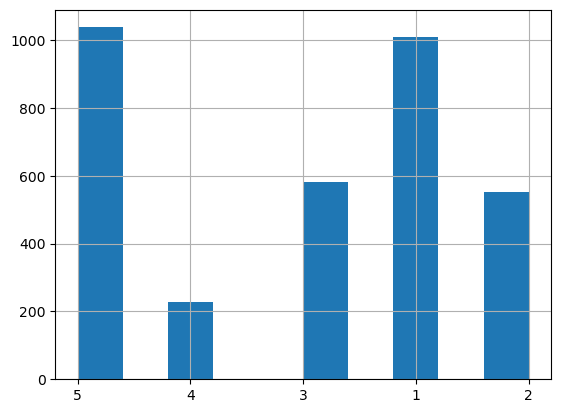

In [4]:
df.rating.hist()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3413 entries, 0 to 3412
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  3409 non-null   object
 1   rating   3409 non-null   object
dtypes: object(2)
memory usage: 53.5+ KB


In [6]:
# remove rows with missing values
df = df.dropna()

In [7]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [8]:
tokenizer = get_tokenizer('spacy', language='de_core_news_sm')

# create iterator from tokenized df
def df_iterator_content(df):
    for _, row in df.iterrows():
        yield tokenizer(row['content'])


In [9]:
vocab = build_vocab_from_iterator(df_iterator_content(df), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [10]:
vocab(['Hallo', 'Welt', 'Foo', 'Iphone'])

[1029, 3019, 0, 806]

In [11]:
def text_pipeline(x):                           # die benutzen wir später um Text in Vektoren zu übersetzen
    return vocab(tokenizer(x))   
    
label_pipeline = lambda x: int(x) - 1           # (andere Schreibweise) die ratings liegen als Text vor und gehen von 1 bis 5. Daher -1

In [12]:
text_pipeline('Die letzte Bestellung, war fehlerhaft') # Beispiel

[32, 1131, 1026, 2, 36, 8268]

In [13]:
from torch.utils.data import DataLoader
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    '''
    Extrahiert aus einer Batch von Text die Labels und die Texte und übersetzt diese in Vektoren(Zahlen-Arrays) mittels text_pipeline und label_pipeline
    '''
    label_list, text_list, offsets = [], [], [0]
    for (_text, _label) in batch:
         label_list.append(label_pipeline(_label))
         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

# check if collate_batch works
collate_batch([("Das neue IPhone ist wirklich toll!!", "5"), ("FritzBox 7830 ist schon ganz nett, aber geht besser", "3")])

(tensor([4, 2]),
 tensor([  28,  212,  472,    6,  122,  656,   18,   18,  778,    0,    6,   61,
          145, 2043,    2,   26,  146,  129]),
 tensor([0, 8]))

In [14]:
from torch import nn

class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [15]:
num_class = df["rating"].nunique()
vocab_size = len(vocab)
emsize = 64

In [16]:
import time



def evaluate(model, dataloader):
    model.eval()
    total_acc, total_count = 0, 0
    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

In [17]:
from torch.utils.data.dataset import random_split

train_dataset=df[['content', 'rating']].values;

num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = \
    random_split(train_dataset, [num_train, len(train_dataset) - num_train])

-----------------------------------------------------------
| end of epoch   1 | time:  3.62s | train accuracy    0.370 | valid accuracy    0.392 | lr: 5.00
-----------------------------------------------------------
| end of epoch   2 | time:  3.49s | train accuracy    0.537 | valid accuracy    0.456 | lr: 5.00
-----------------------------------------------------------
| end of epoch   3 | time:  3.24s | train accuracy    0.523 | valid accuracy    0.509 | lr: 5.00
-----------------------------------------------------------
| end of epoch   4 | time:  3.50s | train accuracy    0.609 | valid accuracy    0.550 | lr: 3.50
-----------------------------------------------------------
| end of epoch   5 | time:  3.60s | train accuracy    0.612 | valid accuracy    0.515 | lr: 3.50
-----------------------------------------------------------
| end of epoch   6 | time:  3.05s | train accuracy    0.652 | valid accuracy    0.579 | lr: 3.50
----------------------------------------------------------

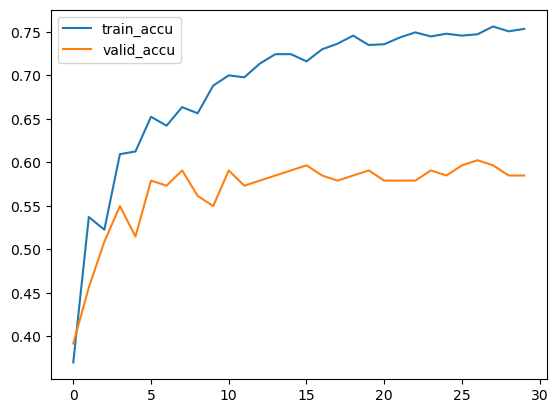

In [18]:
# Hyperparameters
EPOCHS = 30 # epoch
LR = 5  # learning rate
BATCH_SIZE = 64 # batch size for training

model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)

valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE,collate_fn=collate_batch)

loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 3.0, gamma=0.7)   # every 3 epochs, LR is multiplied by 0.7
total_accu = None

train_accus=[]
valid_accus=[]


for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    
    model.train()
    total_acc, total_count = 0, 0

    for idx, (label, text, offsets) in enumerate(train_dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = loss_func(predicted_label, label)
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()

    accu_train = evaluate(model, train_dataloader)
    accu_valid = evaluate(model, valid_dataloader)
    train_accus.append(accu_train)
    valid_accus.append(accu_valid)
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | train accuracy {:8.3f} | valid accuracy {:8.3f} | lr: {:1.2f}'.format(
                                epoch,
                                time.time() - epoch_start_time,
                                accu_train, 
                                accu_valid, 
                                scheduler.get_last_lr()[0]))

    scheduler.step() # learning rate scheduler after each epoch



import matplotlib.pyplot as plt
plt.plot(train_accus, label='train_accu')
plt.plot(valid_accus, label='valid_accu')
plt.legend()
plt.show()

In [19]:
# how much valid accuracy do we get in a new untrained model?
new_model = TextClassificationModel(vocab_size, emsize, num_class).to(device)
evaluate(new_model, valid_dataloader)


0.1286549707602339